# Module import

In [3]:
import numpy as np
import os
import random
import wandb
import json
import time

from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import Module, Sequential, LeakyReLU, Conv2d, BatchNorm2d, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Linear
import torch.nn.functional as F
from torch.nn.modules.dropout import Dropout

from torchvision import datasets
from torch.utils.data import DataLoader

# seed 고정

In [4]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU 
    
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

# Model

## MyModel

In [5]:
class MyModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MyModel, self).__init__()
        """Base Model"""
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x        
    
    
    
def my_model():
    return MyModel(3, 100)

## VGGNet

In [6]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes=100):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])

        self.fc_layer = nn.Sequential(
            # cifar10의 size가 32x32이므로
            nn.Linear(512*1*1, 4096),
            # 만약 imagenet대회 데이터인 224x224이라면
            # nn.Linear(512*7*7, 4096)
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), 
                     nn.BatchNorm2d(x),   
                     # batchnormalization 층을 사용하는 모델들이 요즘 쓰임
                     # overfitting 억제와 학습속도 개선에 용이하다.
                     nn.ReLU(inplace=True)]
                in_channels = x
    

        return nn.Sequential(*layers)
    
    
    
def VGG11():
    return VGG(vgg_name = 'VGG11', num_classes = 100)

def VGG13():
    return VGG(vgg_name = 'VGG13', num_classes = 100)

def VGG16():
    return VGG(vgg_name = 'VGG16', num_classes = 100)

def VGG19():
    return VGG(vgg_name = 'VGG19', num_classes = 100)

## GoogLeNetV3

In [7]:
class GoogLeNetV3(Module):
    def __init__(self, channels_in = 3):
        super(GoogLeNetV3, self).__init__()
        self.in_block = Sequential(
            Conv2d_BN(channels_in, 32, 3, stride=2, padding=1),  # size /= 2
            Conv2d_BN(32, 32, 3, stride=1, padding=1),
            Conv2d_BN(32, 64, 3, stride=1, padding=1),
            MaxPool2d(3, stride=2, padding=1),  # size /= 2
            Conv2d_BN(64, 80, 1, stride=1, padding=0),
            Conv2d_BN(80, 192, 3, stride=1, padding=1),
            MaxPool2d(3, stride=2, padding=1)  # size /= 2
        )  # 192 channels
        self.mix_block = Sequential(
            InceptionA(192, 32),
            InceptionA(256, 64),
            InceptionA(288, 64),
            InceptionB(288),  # size /= 2
            InceptionC(768, 128),
            InceptionC(768, 160),
            InceptionC(768, 160),
            InceptionC(768, 192),
            InceptionD(768),  # size /= 2
            InceptionE(1280),
            InceptionE(2048)
        )  # 2048 channels
        self.out_block = Sequential(
            Conv2d_BN(2048, 1024, 1, stride=1, padding=0),
            AdaptiveAvgPool2d(1)
        )  # 1024 channels
        self.full_connect = Linear(1024, 100)
        
    def forward(self, x):
        x = self.in_block(x)
        x = self.mix_block(x)
        x = self.out_block(x)
        x = torch.flatten(x, 1)
        return self.full_connect(x)

class Conv2d_BN(Module):
    def __init__(self, channels_in, channels_out, kernel_size, padding, stride=1, acti=LeakyReLU(0.2, inplace=True)):
        super(Conv2d_BN, self).__init__()
        self.conv2d_bn = Sequential(
            Conv2d(channels_in, channels_out, kernel_size, stride, padding, bias=False),
            BatchNorm2d(channels_out),
            acti
        )

    def forward(self, x):
        return self.conv2d_bn(x)

class InceptionA(Module):
    def __init__(self, channels_in, pool_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = Conv2d_BN(channels_in, 64, 1, stride=1, padding=0)  # 64 channels
        self.branch5x5 = Sequential(
            Conv2d_BN(channels_in, 48, 1, stride=1, padding=0),
            Conv2d_BN(48, 64, 5, stride=1, padding=2)
        )  # 64 channels
        self.branch3x3dbl = Sequential(
            Conv2d_BN(channels_in, 64, 1, stride=1, padding=0),
            Conv2d_BN(64, 96, 3, stride=1, padding=1),
            Conv2d_BN(96, 96, 3, stride=1, padding=1)
        )  # 96 channels
        self.branch_pool = Sequential(
            AvgPool2d(3, stride=1, padding=1),
            Conv2d_BN(channels_in, pool_channels, 1, stride=1, padding=0)
        )  # pool_channels

    def forward(self, x):
        outputs = [self.branch1x1(x), self.branch5x5(x), self.branch3x3dbl(x), self.branch_pool(x)]
        # 64 + 64 + 96 + pool_channels
        return torch.cat(outputs, 1)

class InceptionB(Module):
    def __init__(self, channels_in):
        super(InceptionB, self).__init__()
        self.branch3x3 = Conv2d_BN(channels_in, 384, 3, stride=2, padding=1)  # 384 channels
        self.branch3x3dbl = Sequential(
            Conv2d_BN(channels_in, 64, 1, padding=0),
            Conv2d_BN(64, 96, 3, padding=1),
            Conv2d_BN(96, 96, 3, stride=2, padding=1)
        )  # 96 channels
        self.branch_pool = MaxPool2d(3, stride=2, padding=1)  # channels_in

    def forward(self, x):
        outputs = [self.branch3x3(x), self.branch3x3dbl(x), self.branch_pool(x)]
        # 384 + 96 + channels_in
        return torch.cat(outputs, 1)

class InceptionC(Module):
    def __init__(self, channels_in, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = Conv2d_BN(channels_in, 192, 1, stride=1, padding=0)  # 192 channels
        self.branch7x7 = Sequential(
            Conv2d_BN(channels_in, channels_7x7, 1, stride=1, padding=0),
            Conv2d_BN(channels_7x7, channels_7x7, (1, 7), stride=1, padding=(0, 3)),
            Conv2d_BN(channels_7x7, 192, (7, 1), stride=1, padding=(3, 0))
        )  # 192 channels
        self.branch7x7dbl = Sequential(
            Conv2d_BN(channels_in, channels_7x7, 1, stride=1, padding=0),
            Conv2d_BN(channels_7x7, channels_7x7, (7, 1), stride=1, padding=(3, 0)),
            Conv2d_BN(channels_7x7, channels_7x7, (1, 7), stride=1, padding=(0, 3)),
            Conv2d_BN(channels_7x7, channels_7x7, (7, 1), stride=1, padding=(3, 0)),
            Conv2d_BN(channels_7x7, 192, (1, 7), stride=1, padding=(0, 3))
        )  # 192 channels
        self.branch_pool = Sequential(
            AvgPool2d(3, stride=1, padding=1),
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0)
        )  # 192 channels
    
    def forward(self, x):
        outputs = [self.branch1x1(x), self.branch7x7(x), self.branch7x7dbl(x), self.branch_pool(x)]
        # 192 + 192 + 192 + 192 = 768 channels
        return torch.cat(outputs, 1)

class InceptionD(Module):
    def __init__(self, channels_in):
        super(InceptionD, self).__init__()
        self.branch3x3 = Sequential(
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0),
            Conv2d_BN(192, 320, 3, stride=2, padding=1)
        )  # 320 channels
        self.branch7x7x3 = Sequential(
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0),
            Conv2d_BN(192, 192, (1, 7), stride=1, padding=(0, 3)),
            Conv2d_BN(192, 192, (7, 1), stride=1, padding=(3, 0)),
            Conv2d_BN(192, 192, 3, stride=2, padding=1)
        )  # 192 chnnels
        self.branch_pool = MaxPool2d(3, stride=2, padding=1)  # channels_in

    def forward(self, x):
        outputs = [self.branch3x3(x), self.branch7x7x3(x), self.branch_pool(x)]
        # 320 + 192 + channels_in
        return torch.cat(outputs, 1)

class InceptionE(Module):
    def __init__(self, channels_in):
        super(InceptionE, self).__init__()
        self.branch1x1 = Conv2d_BN(channels_in, 320, 1, stride=1, padding=0)  # 320 channels

        self.branch3x3_1 = Conv2d_BN(channels_in, 384, 1, stride=1, padding=0)
        self.branch3x3_2a = Conv2d_BN(384, 384, (1, 3), stride=1, padding=(0, 1))
        self.branch3x3_2b = Conv2d_BN(384, 384, (3, 1), stride=1, padding=(1, 0))
        # 768 channels

        self.branch3x3dbl_1 = Sequential(
            Conv2d_BN(channels_in, 448, 1, stride=1, padding=0),
            Conv2d_BN(448, 384, 3, stride=1, padding=1)
        )
        self.branch3x3dbl_2a = Conv2d_BN(384, 384, (1, 3), stride=1, padding=(0, 1))
        self.branch3x3dbl_2b = Conv2d_BN(384, 384, (3, 1), stride=1, padding=(1, 0))
        # 768 channels
        
        self.branch_pool = Sequential(
            AvgPool2d(3, stride=1, padding=1),
            Conv2d_BN(channels_in, 192, 1, stride=1, padding=0)
        )  # 192 channels
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = torch.cat([self.branch3x3_2a(branch3x3), self.branch3x3_2b(branch3x3)], 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = torch.cat([self.branch3x3dbl_2a(branch3x3dbl), self.branch3x3dbl_2b(branch3x3dbl)], 1)

        branch_pool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        # 320 + 768 + 768 + 192 = 2048 channels
        return torch.cat(outputs, 1)

## ResNet

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

# dataset

In [9]:
def create_dataset(datadir: str, aug_name: str = 'default'):
    trainset = datasets.CIFAR100(
        root      = os.path.join(datadir,'CIFAR100'), 
        train     = True, 
        download  = True, 
        transform = __import__('datasets').__dict__[f'{aug_name}_augmentation']()
    )
    testset = datasets.CIFAR100(
        root      = os.path.join(datadir,'CIFAR100'), 
        train     = False, 
        download  = True, 
        transform = __import__('datasets').__dict__['test_augmentation']()
    )

    return trainset, testset


def create_dataloader(dataset, batch_size: int = 4, shuffle: bool = False):

    return DataLoader(
        dataset     = dataset,
        batch_size  = batch_size,
        shuffle     = shuffle,
        num_workers = 0
    )

# Training

In [10]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, criterion, optimizer):
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    acc_m = AverageMeter()
    losses_m = AverageMeter()
    
    end = time.time()
    
    model.train()
    optimizer.zero_grad()
    for idx, (inputs, targets) in enumerate(dataloader):
        data_time_m.update(time.time() - end)
        
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # predict
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # loss update
        optimizer.step()
        optimizer.zero_grad()
        losses_m.update(loss.item())
        
        # accuracy
        pred = outputs.argmax(dim=1)
        acc_m.update(targets.eq(pred).sum().item()/targets.size(0), n=targets.size(0))
        
        batch_time_m.update(time.time() - end)
        end = time.time()
        
    return OrderedDict([('acc',acc_m.avg), ('loss',losses_m.avg)])


def test(model, dataloader, criterion):
    correct = 0
    total = 0
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for idx, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            # predict
            outputs = model(inputs)
            
            # loss
            loss = criterion(outputs, targets)
            
            # total loss & acc
            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            correct += targets.eq(pred).sum().item()
            total += targets.size(0)
            
        return OrderedDict([('acc',correct/total), ('loss',total_loss/len(dataloader))])
    
    
def fit(
    model, trainloader, testloader, criterion, optimizer, scheduler,
    epochs: int, use_wandb: bool, savedir: str, early_stopping: bool = False
) -> None:
    
    best_acc = 0
    step = 0
    
    for epoch in range(epochs):
        print(f"epoch : {epoch}")
        train_metrics = train(model = model,
                              dataloader = trainloader,
                              criterion = criterion,
                              optimizer = optimizer
                             )
        
        eval_metrics = test(model = model,
                            dataloader = testloader,
                            criterion = criterion
                           )
        print(f"acc : {eval_metrics['acc']}, loss : {eval_metrics['loss']}")
        
        if scheduler:
            scheduler.step()
            
        # wandb
        if use_wandb:
            metrics = OrderedDict(lr=optimizer.param_groups[0]['lr'])
            metrics.update([('train_' + k, v) for k, v in train_metrics.items()])
            metrics.update([('eval_' + k, v) for k, v in eval_metrics.items()])
            wandb.log(metrics, step=step)
        
        step += 1
        
        # checkpoint
        if best_acc < eval_metrics['acc']:
            # save results
            state = {'best_epoch':epoch, 'best_acc':eval_metrics['acc']}
            json.dump(state, open(os.path.join(savedir, f'best_results.json'),'w'), indent=4)
            
            # save model
            torch.save(model.state_dict(), os.path.join(savedir, f'best_model.pt'))
            
            best_acc = eval_metrics['acc']
            print(f"best_acc : {eval_metrics['acc']}")
        else:    
            print(f"best_acc : {best_acc}")
            
        # early stopping
        if early_stopping:
            keep = 0
            stop = 15
            if best_acc > eval_metrics['acc']:
                keep += 1
                print(f"Accuracy has not improved for {keep} epoch.")
                if keep > stop:
                    print("Early Stopping is working")
                    print(f"The best Accuracy is {best_acc}")

In [11]:
# experiment setting
model_name = "my_model"   # 사용할 모델이름
exp_name = "my_model_SGD"   # 실험 제목
datadir = "./datasets"   # 데이터셋 디렉토리
savedir = "./saved_model"   # weight 저장 디렉토리

# optimizer
opt_name = "SGD"
lr = 0.1

# augmentation
aug_name = "default" # default 와 weak 두 종류 중 선택

# training
epochs = 50
batch_size = 128

# seed
seed = 1201 # 시드 고정 (제 생일입니다.)

# wandb
use_wandb = False  # wandb tool 사용 여부

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models = {
    'my_model': my_model,

    'ResNet18': ResNet18,
    'ResNet34': ResNet34,
    'ResNet50': ResNet50,

    'VGG11' : VGG11,
    'VGG13' : VGG13,
    'VGG16' : VGG16,
    'VGG19' : VGG19,

    'GoogLeNetV3' : GoogLeNetV3
}

model = models[model_name]().to(DEVICE) # arg

# load dataset
trainset, testset = create_dataset(datadir=datadir, aug_name=aug_name) # arg

# load dataloader
trainloader = create_dataloader(dataset=trainset, batch_size=batch_size, shuffle=True)  # arg
testloader = create_dataloader(dataset=testset, batch_size=256, shuffle=False)

# set training
criterion = torch.nn.CrossEntropyLoss()
optimizer = __import__('torch.optim', fromlist='optim').__dict__[opt_name](model.parameters(), lr=lr) # arg


# scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs, eta_min=0.00001) # arg


# make save directory
savedir = os.path.join(savedir, exp_name)  # arg
os.makedirs(savedir, exist_ok=True)

# # initialize wandb
# if use_wandb:  # arg : use_wandb
#     wandb.init(name=args.exp_name, project='CIFAR100 Test', config=args) # arg

# fitting model
fit(model        = model, 
    trainloader  = trainloader, 
    testloader   = testloader, 
    criterion    = criterion, 
    optimizer    = optimizer, 
    scheduler    = scheduler,
    epochs       = epochs,   # arg
    savedir      = savedir,
    use_wandb    = use_wandb) # arg

Files already downloaded and verified
Files already downloaded and verified
epoch : 0


40it [00:01, 34.63it/s]


acc : 0.0695, loss : 4.081896102428436
best_acc : 0.0695
epoch : 1


40it [00:01, 34.63it/s]


acc : 0.1312, loss : 3.7317083299160005
best_acc : 0.1312
epoch : 2


40it [00:01, 34.56it/s]


acc : 0.1635, loss : 3.597917938232422
best_acc : 0.1635
epoch : 3


40it [00:01, 35.23it/s]


acc : 0.1775, loss : 3.4364544808864594
best_acc : 0.1775
epoch : 4


40it [00:01, 35.30it/s]


acc : 0.1709, loss : 3.5680306911468507
best_acc : 0.1775
epoch : 5


40it [00:01, 35.19it/s]


acc : 0.2199, loss : 3.2239899396896363
best_acc : 0.2199
epoch : 6


40it [00:01, 35.05it/s]


acc : 0.2466, loss : 3.1514718353748323
best_acc : 0.2466
epoch : 7


40it [00:01, 33.57it/s]


acc : 0.2342, loss : 3.1791089951992033
best_acc : 0.2466
epoch : 8


40it [00:01, 35.44it/s]


acc : 0.2415, loss : 3.1131880581378937
best_acc : 0.2466
epoch : 9


40it [00:01, 35.15it/s]


acc : 0.2445, loss : 3.142132991552353
best_acc : 0.2466
epoch : 10


40it [00:01, 35.18it/s]


acc : 0.2322, loss : 3.231425279378891
best_acc : 0.2466
epoch : 11


40it [00:01, 34.21it/s]


acc : 0.2729, loss : 2.9872231423854827
best_acc : 0.2729
epoch : 12


40it [00:01, 35.03it/s]


acc : 0.272, loss : 2.9926662266254427
best_acc : 0.2729
epoch : 13


40it [00:01, 35.23it/s]


acc : 0.2132, loss : 3.47018620967865
best_acc : 0.2729
epoch : 14


40it [00:01, 35.26it/s]


acc : 0.2674, loss : 3.0718216240406035
best_acc : 0.2729
epoch : 15


40it [00:01, 34.88it/s]


acc : 0.2668, loss : 3.0989909946918486
best_acc : 0.2729
epoch : 16


40it [00:01, 33.76it/s]


acc : 0.2683, loss : 3.1061762034893037
best_acc : 0.2729
epoch : 17


40it [00:01, 33.34it/s]


acc : 0.2648, loss : 3.0819057285785676
best_acc : 0.2729
epoch : 18


40it [00:01, 35.17it/s]


acc : 0.2642, loss : 3.0758492290973662
best_acc : 0.2729
epoch : 19


40it [00:01, 35.00it/s]


acc : 0.2839, loss : 3.0169371366500854
best_acc : 0.2839
epoch : 20


40it [00:01, 35.09it/s]


acc : 0.2792, loss : 3.0951662361621857
best_acc : 0.2839
epoch : 21


40it [00:01, 34.20it/s]


acc : 0.2804, loss : 3.0319660305976868
best_acc : 0.2839
epoch : 22


40it [00:01, 35.33it/s]


acc : 0.2852, loss : 3.1327332735061644
best_acc : 0.2852
epoch : 23


40it [00:01, 35.35it/s]


acc : 0.2798, loss : 3.149879938364029
best_acc : 0.2852
epoch : 24


40it [00:01, 35.33it/s]


acc : 0.281, loss : 3.102899557352066
best_acc : 0.2852
epoch : 25


40it [00:01, 35.30it/s]


acc : 0.286, loss : 3.129017150402069
best_acc : 0.286
epoch : 26


40it [00:01, 35.17it/s]


acc : 0.2845, loss : 3.186607748270035
best_acc : 0.286
epoch : 27


40it [00:01, 34.88it/s]


acc : 0.284, loss : 3.1791546165943148
best_acc : 0.286
epoch : 28


40it [00:01, 33.98it/s]


acc : 0.274, loss : 3.3770865976810454
best_acc : 0.286
epoch : 29


40it [00:01, 35.14it/s]


acc : 0.2863, loss : 3.2299775421619414
best_acc : 0.2863
epoch : 30


40it [00:01, 35.47it/s]


acc : 0.2875, loss : 3.2775173783302307
best_acc : 0.2875
epoch : 31


40it [00:01, 35.35it/s]


acc : 0.284, loss : 3.3090361654758453
best_acc : 0.2875
epoch : 32


40it [00:01, 35.38it/s]


acc : 0.2862, loss : 3.3100417375564577
best_acc : 0.2875
epoch : 33


40it [00:01, 35.39it/s]


acc : 0.2816, loss : 3.419365656375885
best_acc : 0.2875
epoch : 34


40it [00:01, 35.16it/s]


acc : 0.286, loss : 3.3918699264526366
best_acc : 0.2875
epoch : 35


40it [00:01, 35.43it/s]


acc : 0.2821, loss : 3.465256083011627
best_acc : 0.2875
epoch : 36


40it [00:01, 35.43it/s]


acc : 0.28, loss : 3.443953639268875
best_acc : 0.2875
epoch : 37


40it [00:01, 35.39it/s]


acc : 0.2885, loss : 3.473532098531723
best_acc : 0.2885
epoch : 38


40it [00:01, 35.33it/s]


acc : 0.2847, loss : 3.506110554933548
best_acc : 0.2885
epoch : 39


40it [00:01, 35.30it/s]


acc : 0.2841, loss : 3.5275960743427275
best_acc : 0.2885
epoch : 40


40it [00:01, 35.23it/s]


acc : 0.2847, loss : 3.5615880310535433
best_acc : 0.2885
epoch : 41


40it [00:01, 35.44it/s]


acc : 0.2842, loss : 3.5764032661914826
best_acc : 0.2885
epoch : 42


40it [00:01, 34.37it/s]


acc : 0.2815, loss : 3.596117204427719
best_acc : 0.2885
epoch : 43


40it [00:01, 35.17it/s]


acc : 0.2818, loss : 3.618023145198822
best_acc : 0.2885
epoch : 44


40it [00:01, 35.45it/s]


acc : 0.2835, loss : 3.6272421181201935
best_acc : 0.2885
epoch : 45


40it [00:01, 33.72it/s]


acc : 0.2851, loss : 3.642912518978119
best_acc : 0.2885
epoch : 46


40it [00:01, 35.29it/s]


acc : 0.2827, loss : 3.6482555985450746
best_acc : 0.2885
epoch : 47


40it [00:01, 35.27it/s]


acc : 0.285, loss : 3.652283239364624
best_acc : 0.2885
epoch : 48


40it [00:01, 34.95it/s]


acc : 0.2836, loss : 3.6573058366775513
best_acc : 0.2885
epoch : 49


40it [00:01, 35.23it/s]

acc : 0.2846, loss : 3.6574875175952912
best_acc : 0.2885


# Result

## Model

**Models used in the experiment**
- my_model

- VGGNet
    - VGG11
    - VGG13
    - VGG16
    - VGG19
    
- ResNet
    - ResNet18
    - ResNet34
    - ResNet50
    
- GoogLeNet
    - InceptionV3

**preprocessing**
- optimizer : SGD
- Learning rate : CosineAnnealingWarmRestarts scheduler 사용
- augmentation : default
- epoch : 50
- batch size : 128

In [1]:
import json
%cd saved_model/

/project/smcho1201/project/pytorch_cifar100/saved_model


In [2]:
file_path_li = ['./my_model_SGD', # custom model
                './VGG11_SGD', './VGG13_SGD', './VGG16_SGD', './VGG19_SGD', # VGGNet
                './ResNet18_SGD', './ResNet34_SGD', './ResNet50_SGD'] # ResNet

#json data 열기
for file_path in file_path_li:
    print(f"model : {file_path[2:-4]}")
    with open(file_path+"/best_results.json", encoding='utf-8') as f:
        data = json.load(f)
        print(data)

model : my_model
{'best_epoch': 37, 'best_acc': 0.2885}
model : VGG11
{'best_epoch': 42, 'best_acc': 0.5583}
model : VGG13
{'best_epoch': 43, 'best_acc': 0.582}
model : VGG16
{'best_epoch': 42, 'best_acc': 0.5902}
model : VGG19
{'best_epoch': 48, 'best_acc': 0.5802}
model : ResNet18
{'best_epoch': 18, 'best_acc': 0.5747}
model : ResNet34
{'best_epoch': 27, 'best_acc': 0.577}
model : ResNet50
{'best_epoch': 40, 'best_acc': 0.5078}


### best model top-3
**model : VGG16**
- {'best_epoch': 42, 'best_acc': 0.5902}

**model : VGG13**
- {'best_epoch': 43, 'best_acc': 0.582}

**model : VGG19**
- {'best_epoch': 48, 'best_acc': 0.5802}

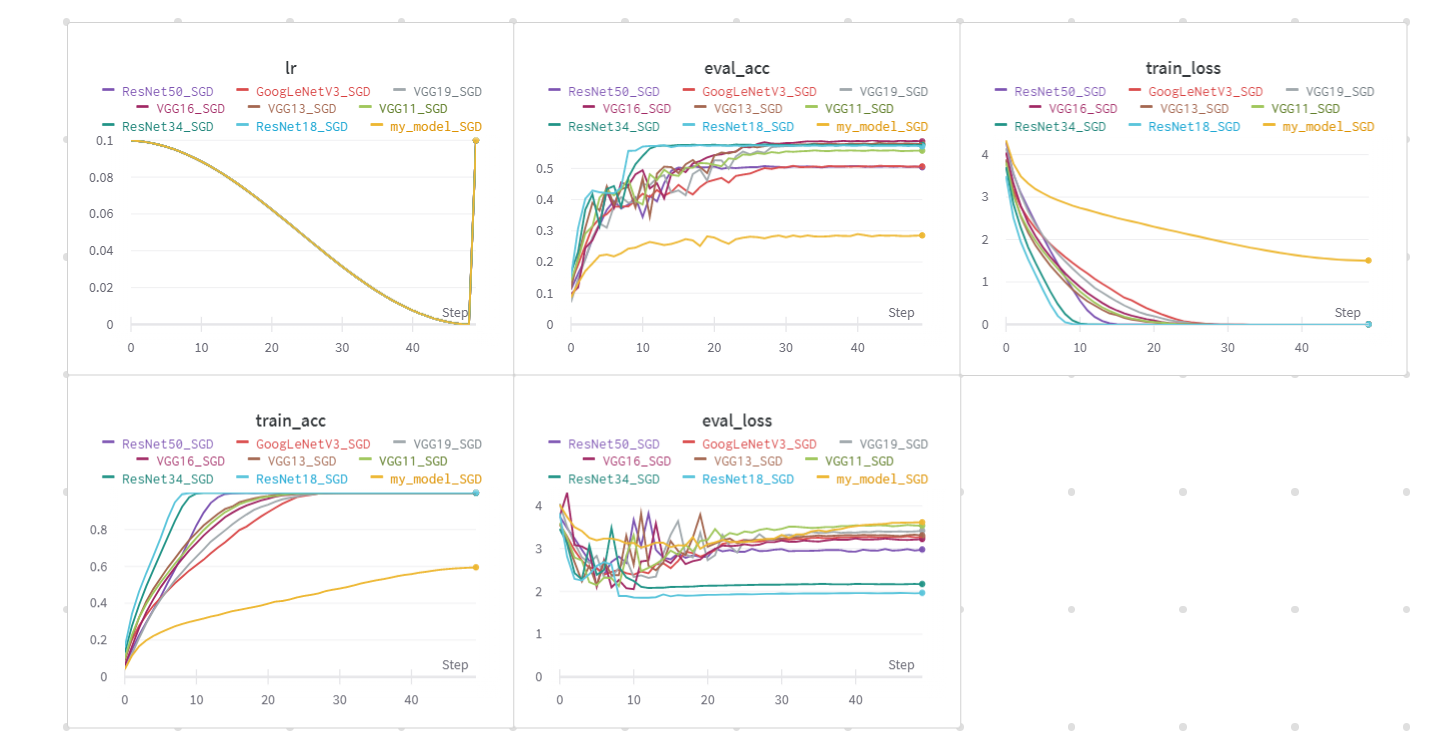

---
성능이 좋은 모델의 base는 모두 **VGGNet**으로 나타난다.

하지만 VGGNet 기반 모델들의 경우 best acc일 때의 epoch이 40번 대인 것에 반해, ResNet 기반 모델들은 10, 20번대 epoch에 성능이 더이상 오르지 않았다. 이는 **overfitting**의 문제가 의심된다.

즉, 깊은 모델에 비해 데이터셋의 크기가 작아 성능이 나오지 않은 것도 고려를 해야하기 때문에 

다음 두 모델 **VGG16**, **ResNet34** 에 대해 **augmentation**을 적용하여 다시 실험을 진행하였다.

---

## Augmentation

In [3]:
file_path_li = ['./VGG16_aug', 
                './ResNet34_aug', 
                './ResNet50_aug'] 

#json data 열기
for file_path in file_path_li:
    print(f"model : {file_path[2:-4]}")
    with open(file_path+"/best_results.json", encoding='utf-8') as f:
        data = json.load(f)
        print(data)

model : VGG16
{'best_epoch': 48, 'best_acc': 0.6707}
model : ResNet34
{'best_epoch': 49, 'best_acc': 0.7081}
model : ResNet50
{'best_epoch': 47, 'best_acc': 0.7079}


### best model top-3

**model : VGG16**
- {'best_epoch': 48, 'best_acc': 0.6707}

**model : ResNet34**
- {'best_epoch': 49, 'best_acc': 0.7081}

**model : ResNet50**
- {'best_epoch': 47, 'best_acc': 0.7079}

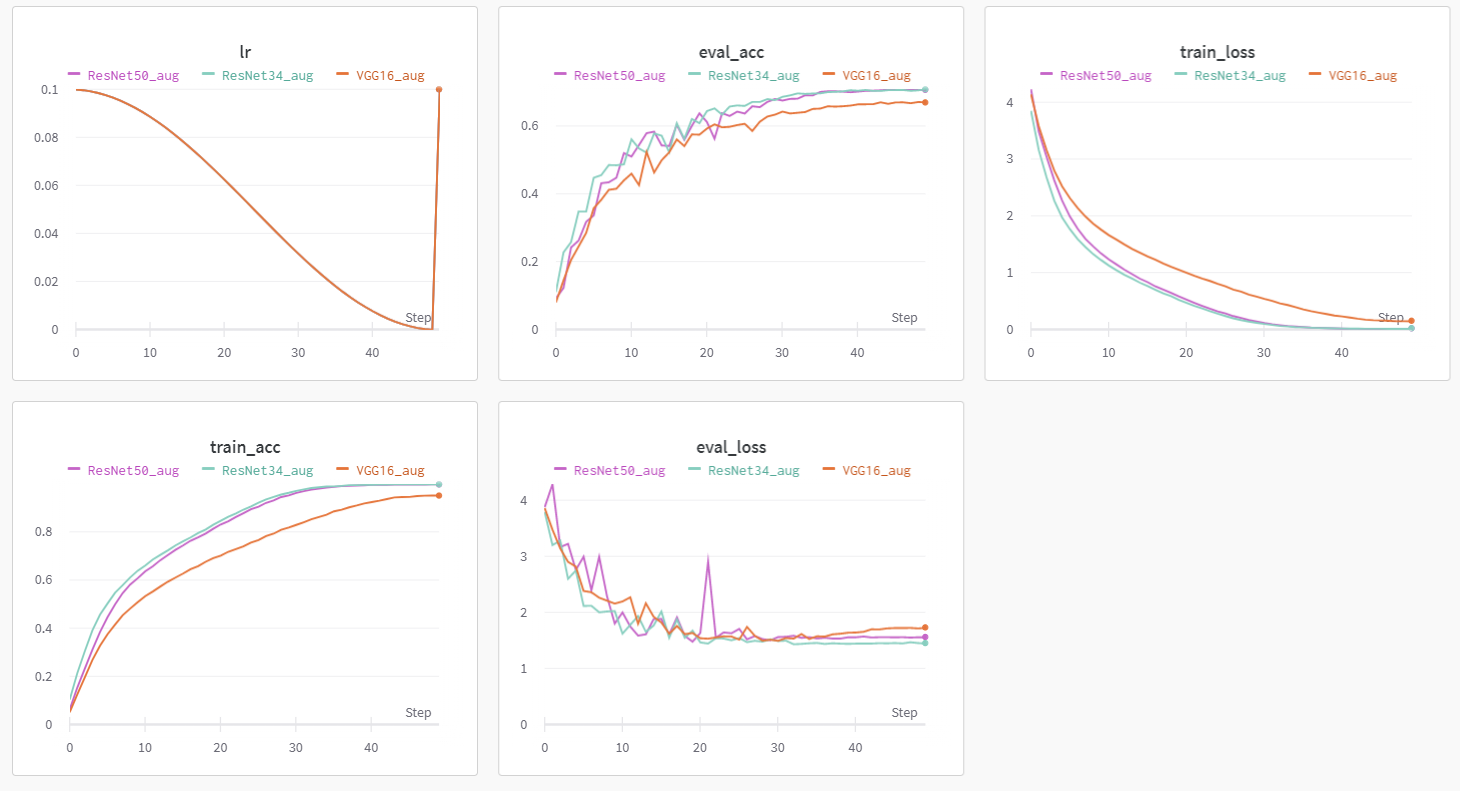

---
**augmentation**을 통해 **overfitting을 다소 완화**하여 실험을 하였더니 새로운 결과가 도출되었다.

default의 상태에서 실험을 하였을 때 top-3가 모두 VGG기반 모델이었던 것에 비해 이번에는 **ResNet기반 모델**들이 더 좋은 성능을 보여주었다.

또한 best_epoch이 모두 총 epoch수인 50에 가까운 것을 보았을 때 overfitting문제가 전과 비해 확실히 어느정도 해결되었음을 알 수 있었으며, epoch 수를 늘려 더 정확도를 늘릴 수 있어 보인다.

추가로 optimizer를 Adam으로 바꾸어 진행해보았는데 전혀 상승을 보이지 않았다. 아무래도 최적화하는 부분에 있어 잘 맞지 않은 모습을 보였던 것 같다.

추가로 **epoch수를 100으로 설정**한 후 다시 실험을 진행하였다.

---

## epoch : 100

In [5]:
file_path_li = ['./VGG16_epoch100', 
                './ResNet34_epoch100', 
                './ResNet50_epoch100'] 

#json data 열기
for file_path in file_path_li:
    print(f"model : {file_path[2:-4]}")
    with open(file_path+"/best_results.json", encoding='utf-8') as f:
        data = json.load(f)
        print(data)

model : VGG16_epoc
{'best_epoch': 92, 'best_acc': 0.6892}
model : ResNet34_epoc
{'best_epoch': 62, 'best_acc': 0.723}
model : ResNet50_epoc
{'best_epoch': 88, 'best_acc': 0.7186}


### beest model top-3

**model : VGG16**
- {'best_epoch': 92, 'best_acc': 0.6892}

**model : ResNet34**
- {'best_epoch': 62, 'best_acc': 0.723}

**model : ResNet50**
- {'best_epoch': 88, 'best_acc': 0.7186}

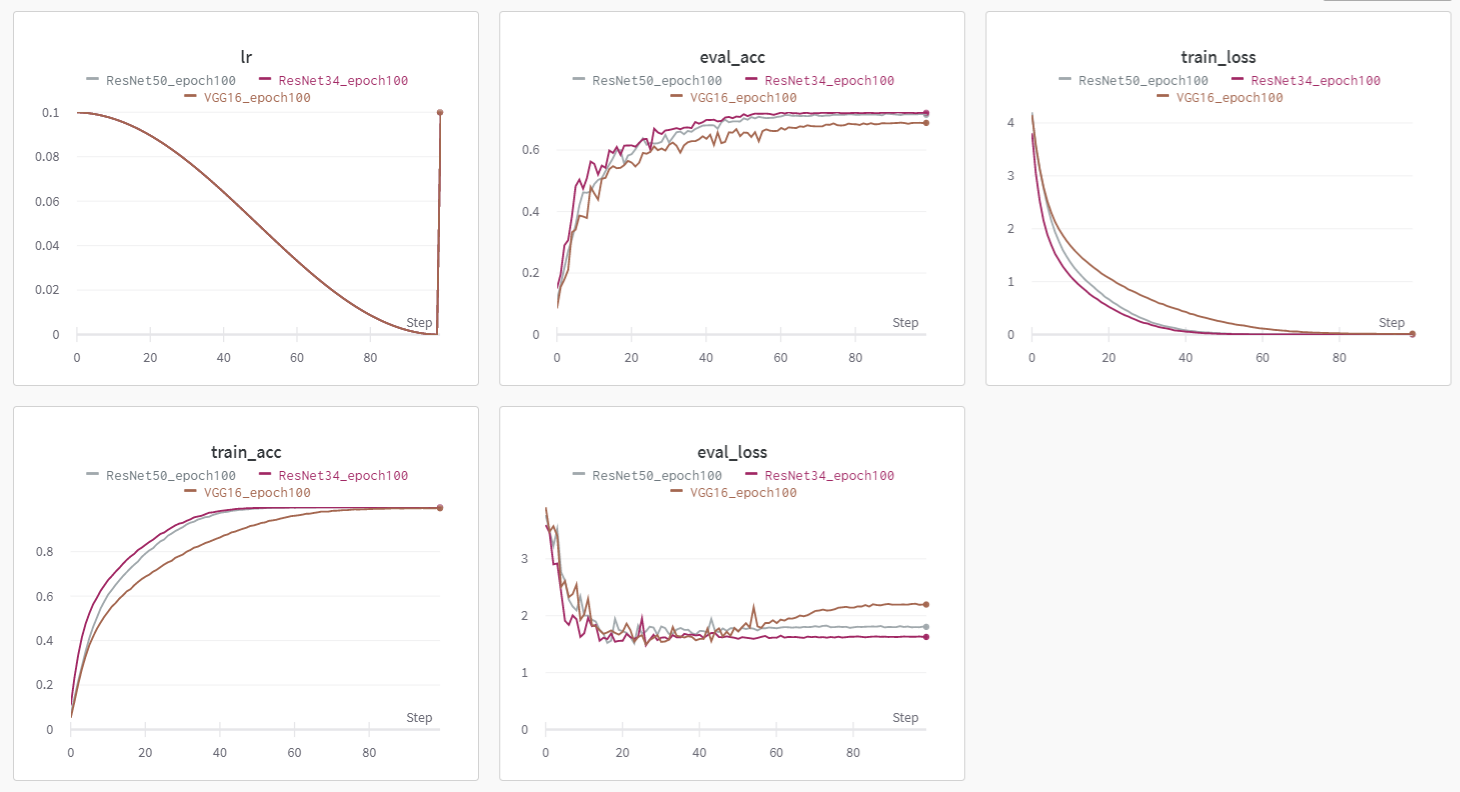

---
전 실험과 비교했을 때 세 모델 모두 2% 정도의 정확도 향상을 보여주었다.

모델 순위는 동일하게 **ResNet34**, **ResNet50**, **VGGNet16** 으로 나타났으며, 가장 성능이 좋았던 **ResNet34**의 경우 validation accuracy가 **72%**까지 향상한 모습을 보여주었다.

물론 추가적으로 **fine tuning**을 하면 더 큰 향상을 기대할 수 있겠지만, 이번 실험에서는 모델과 전처리로 성능을 향상해보이는 것이 취지이기 때문에 따로 진행하지는 않았다.

---